In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import BinaryAccuracy

from distreg import distributions
from distreg.distribution_lr_gp import DistributionLogisticGP
from distreg.distributions import DistributionDataset
from distreg.distributions.distribution import (
    DIST_CLASS_LABELS,
    DIST_CLASSES,
    concatenate_distributions,
)
from distreg.kernels import PolynomialEncoder, RffEncoder
from distreg.utils import plot_normals_predictions, plot_bin_class_predictions

In [4]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device)

cpu


#### Logistic Regressor

In [5]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim=1, bias=False):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=bias)

    def forward(self, x):
        out = self.linear(x)
        return torch.sigmoid(out)

#### Define the training procedure (LBFGS)

In [6]:
criterion = nn.BCELoss(reduction="sum")
batch_size = 16


def train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    epochs,
    batch_size,
    bfgs=False,
    verbose=False,
    plot_curve=False,
):
    batch_size = len(train_dataset) if bfgs else batch_size
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=len(test_dataset), shuffle=False
    )

    train_size = len(train_loader.dataset)
    test_size = len(test_loader.dataset)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []

    for e in range(1, epochs + 1):
        train_loss = 0.0
        train_acc = 0.0
        for _, (data, labels, _) in enumerate(train_loader):
            data = data.to(device)

            def closure1():
                model.zero_grad()
                optimizer.zero_grad()
                y = model(data).flatten()
                loss = criterion(y, labels)
                loss.backward()
                return loss

            if not bfgs:
                model.zero_grad()
                optimizer.zero_grad()

                y = model(data).flatten()
                loss = criterion(y, labels)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
            else:
                optimizer.step(closure1)
                y = model(data).flatten()
                loss = criterion(y, labels)
                train_loss += loss.item()
                train_acc += data.shape[0] * BinaryAccuracy()(y, labels).item()

        with torch.no_grad():
            test_loss = 0.0
            for _, (test_data, labels_test, _) in enumerate(test_loader):
                test_data = test_data.to(device)
                y_test = model(test_data).flatten()
                loss = criterion(y_test, labels_test)
                test_loss += loss.item()
                test_acc = BinaryAccuracy()(y_test, labels_test).item()

        train_loss /= train_size
        test_loss /= test_size

        train_acc /= train_size

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        if e % 50 == 0 and verbose:
            print(
                "Epoch: %d, train loss = %.4f, test loss = %.4f"
                % (e, train_loss, test_loss)
            )

    if plot_curve:
        sns.lineplot(train_losses, label="train")
        plot = sns.lineplot(test_losses, label="test")
        plot.set_title("Loss curve")
        plt.show()

    if plot_curve:
        sns.lineplot(train_accs, label="train")
        plot = sns.lineplot(test_accs, label="test")
        plot.set_title("Accuracy curve")
        plt.show()

    return train_losses, test_losses

## Classify uniformly-spread normals based on mean-variance threshold

#### Normal distributions across uniform range (mu=(0,20), sigma=(0,20))

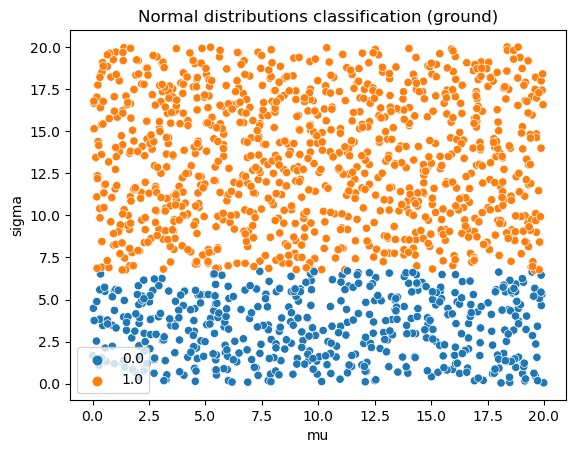

Epoch: 0, train loss = 0.6742, test loss = 0.6758
Epoch: 50, train loss = 0.2806, test loss = 0.3015
Epoch: 100, train loss = 0.1670, test loss = 0.1972
Epoch: 150, train loss = 0.1260, test loss = 0.1631
Epoch: 200, train loss = 0.1095, test loss = 0.1526
Epoch: 250, train loss = 0.1007, test loss = 0.1493
Epoch: 300, train loss = 0.0929, test loss = 0.1454
Epoch: 350, train loss = 0.0891, test loss = 0.1433


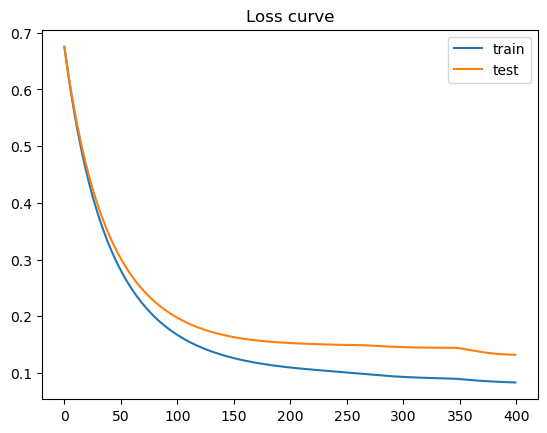

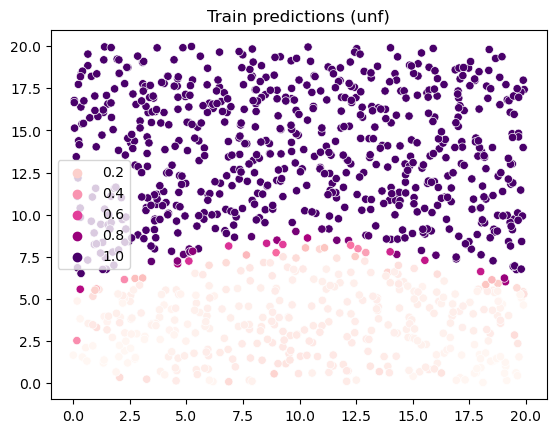

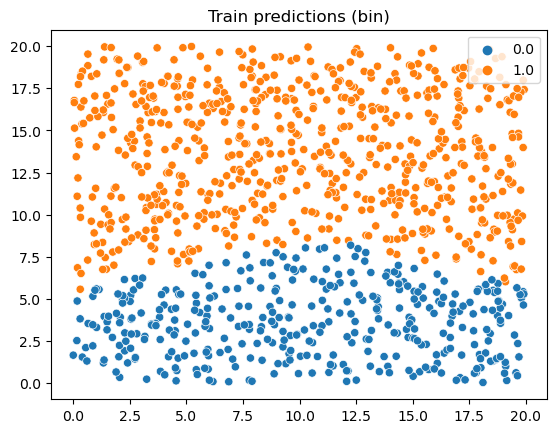

Train Accuracy: 0.9723809361457825


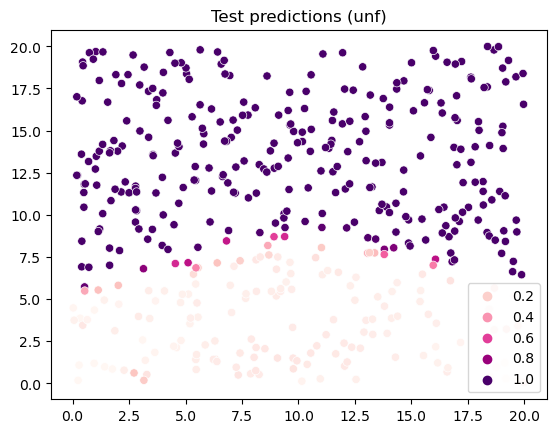

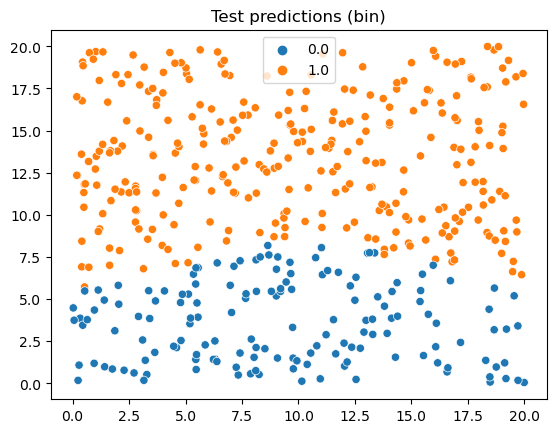

Test accuracy: 0.95333331823349


In [14]:
n_dim = 1

n_distributions = 1500
samples_per_dist = 20000

normals_mu_range = (0, 20)
normals_sigma_range = (0, 20)
class_sigma_threshold = 6.7

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_hline = normal_dists.bin_sigma_gt_labels(class_sigma_threshold)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_hline,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_features = 32
train_ratio = 0.7

rff_encoder = RffEncoder(
    n_features,
    n_dim,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=0.0,
)

logistic_gp = DistributionLogisticGP(
    normal_dists, normal_labels_hline, rff_encoder
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    400,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

#### Normal distributions across larger range (mu=(0,300), sigma=(0,300))

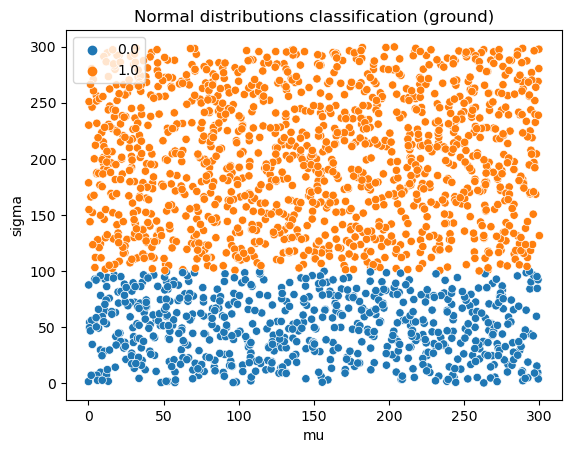

Epoch: 50, train loss = 0.5390, test loss = 0.5397
Epoch: 100, train loss = 0.4230, test loss = 0.4233
Epoch: 150, train loss = 0.3369, test loss = 0.3370
Epoch: 200, train loss = 0.2713, test loss = 0.2712
Epoch: 250, train loss = 0.2203, test loss = 0.2202
Epoch: 300, train loss = 0.1801, test loss = 0.1799
Epoch: 350, train loss = 0.1481, test loss = 0.1480
Epoch: 400, train loss = 0.1224, test loss = 0.1223
Epoch: 450, train loss = 0.1016, test loss = 0.1016
Epoch: 500, train loss = 0.0847, test loss = 0.0848
Epoch: 550, train loss = 0.0708, test loss = 0.0712
Epoch: 600, train loss = 0.0595, test loss = 0.0601
Epoch: 650, train loss = 0.0501, test loss = 0.0510
Epoch: 700, train loss = 0.0424, test loss = 0.0436
Epoch: 750, train loss = 0.0359, test loss = 0.0375
Epoch: 800, train loss = 0.0305, test loss = 0.0324


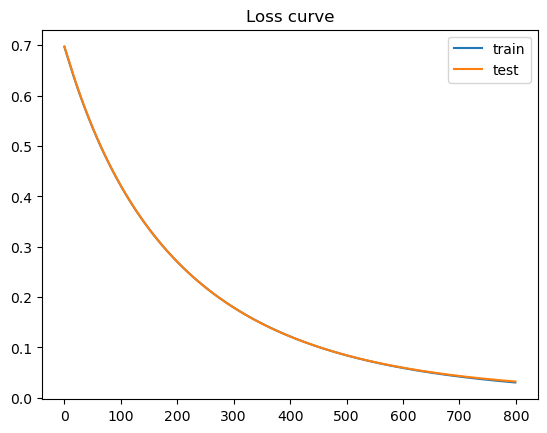

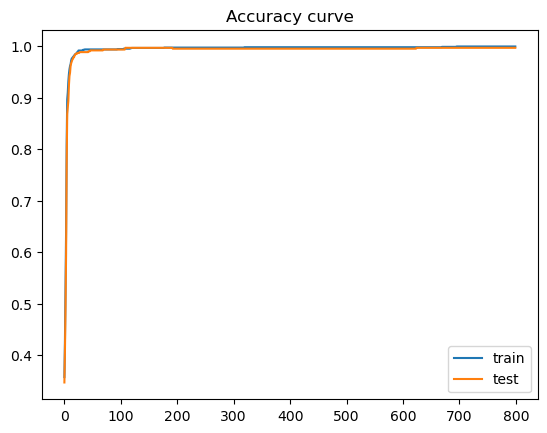

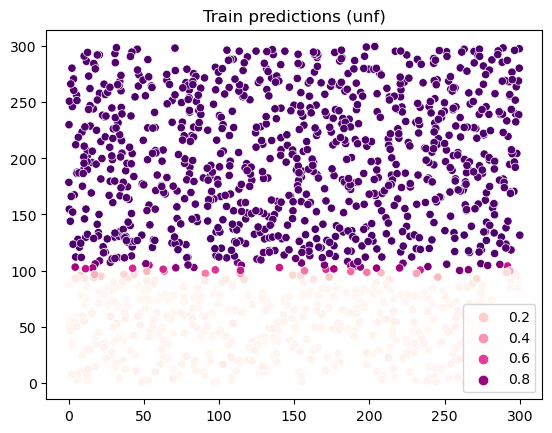

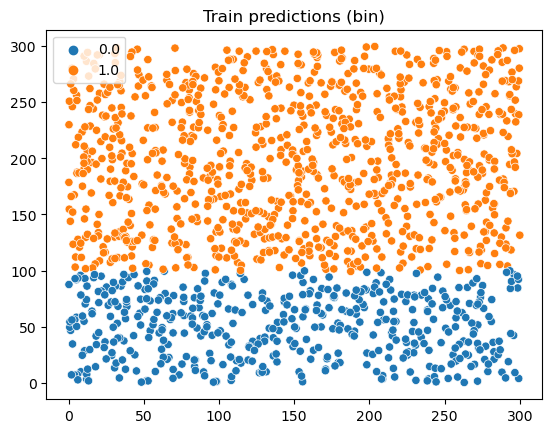

Train Accuracy: 99.929


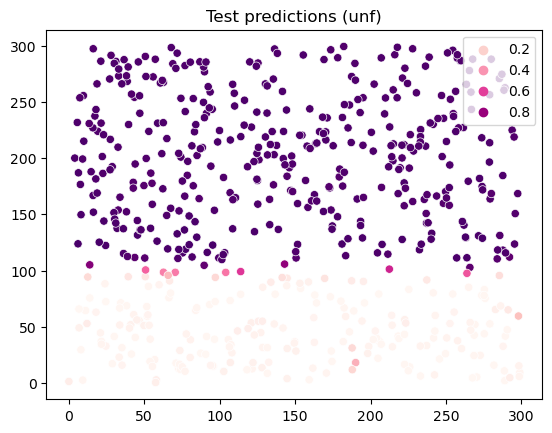

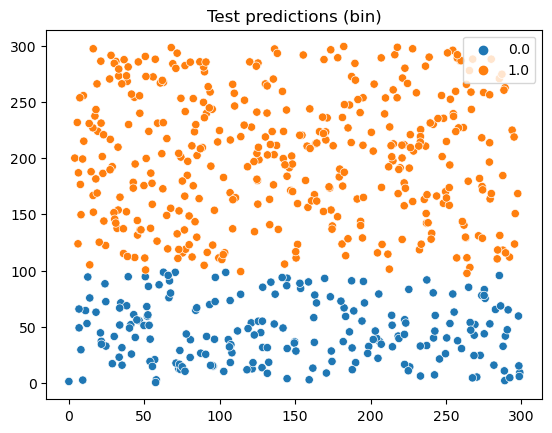

Test accuracy: 99.667


In [22]:
n_dim = 1

n_distributions = 2000
samples_per_dist = 25000

normals_mu_range = (0, 300)
normals_sigma_range = (0, 300)
class_sigma_threshold = 100

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_hline = normal_dists.bin_sigma_gt_labels(class_sigma_threshold)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_hline,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_kme_features = 200
n_features = 200
train_ratio = 0.7

kme_rff_encoder = RffEncoder(
    n_dim,
    n_kme_features,
    kernel="gaussian",
    log_amplitude=1.0,
    log_length_scale=4.0,
)

reg_rff_encoder = RffEncoder(
    n_kme_features,
    n_features,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=-1.0,
)

logistic_gp = DistributionLogisticGP(
    normal_dists,
    normal_labels_hline,
    kme_rff_encoder,
    reg_rff_encoder,
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0002)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    800,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

#### Uniform distributions across mu=(0, 300), sigma=(0, 300)

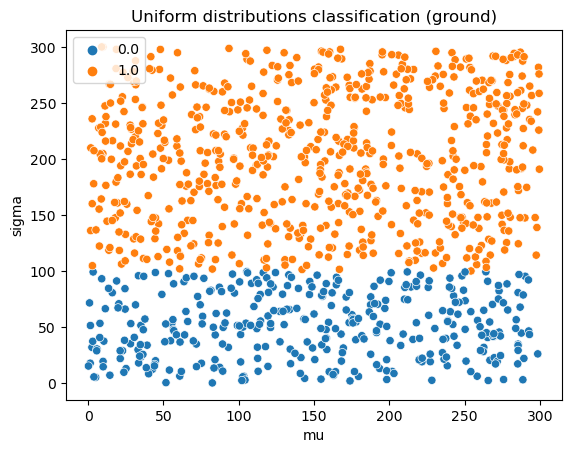

Epoch: 50, train loss = 0.5223, test loss = 0.5237
Epoch: 100, train loss = 0.4083, test loss = 0.4109
Epoch: 150, train loss = 0.3234, test loss = 0.3279
Epoch: 200, train loss = 0.2587, test loss = 0.2651
Epoch: 250, train loss = 0.2083, test loss = 0.2168
Epoch: 300, train loss = 0.1687, test loss = 0.1791
Epoch: 350, train loss = 0.1372, test loss = 0.1493
Epoch: 400, train loss = 0.1119, test loss = 0.1258
Epoch: 450, train loss = 0.0915, test loss = 0.1070
Epoch: 500, train loss = 0.0750, test loss = 0.0920
Epoch: 550, train loss = 0.0616, test loss = 0.0801
Epoch: 600, train loss = 0.0506, test loss = 0.0706
Epoch: 650, train loss = 0.0417, test loss = 0.0631
Epoch: 700, train loss = 0.0343, test loss = 0.0572
Epoch: 750, train loss = 0.0283, test loss = 0.0527
Epoch: 800, train loss = 0.0233, test loss = 0.0493


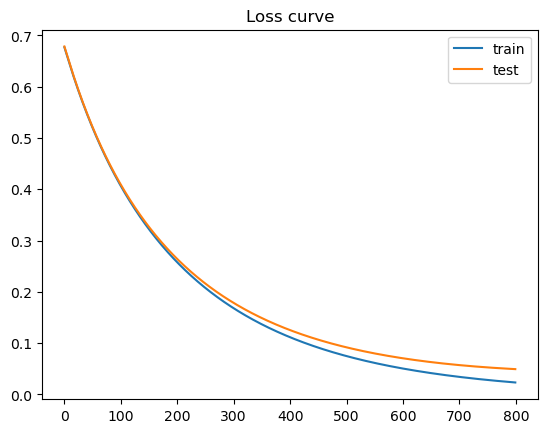

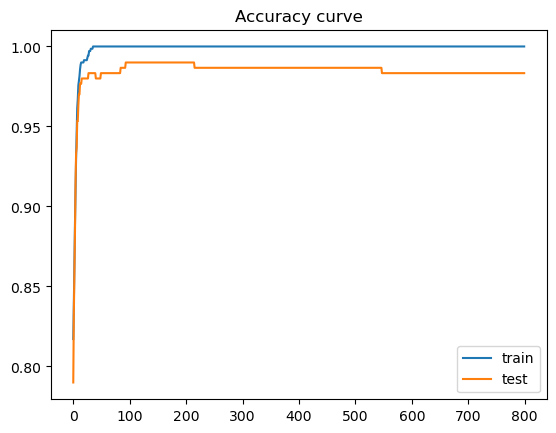

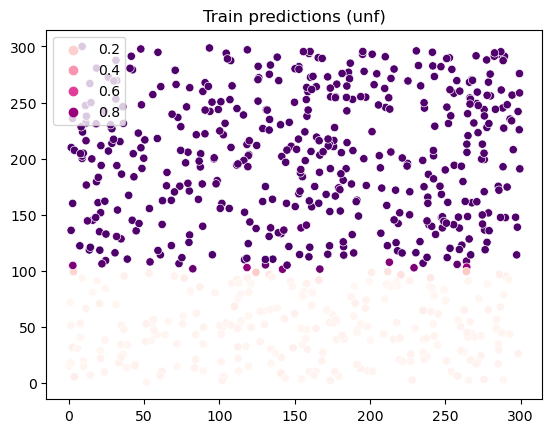

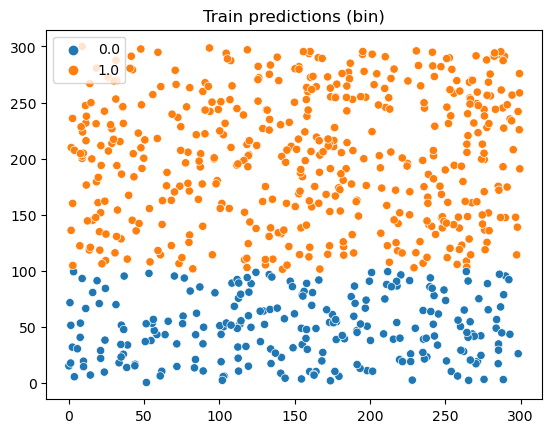

Train Accuracy: 100.0


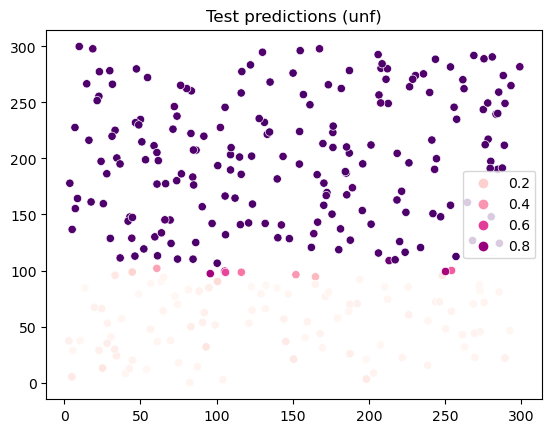

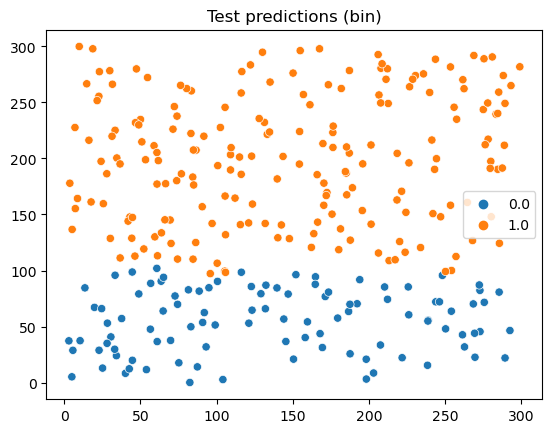

Test accuracy: 98.333


In [11]:
n_dim = 1

n_distributions = 1_000
samples_per_dist = 10_000

unf_mu_range = (0, 300)
unf_sigma_range = (0, 300)
class_sigma_threshold = 100

uniform_dists = distributions.Uniform(
    n_distributions, n_dim, unf_mu_range, unf_sigma_range
)
_ = uniform_dists.sample(samples_per_dist)

uniform_labels_hline = uniform_dists.bin_sigma_gt_labels(class_sigma_threshold)

plot = sns.scatterplot(
    x=uniform_dists.params[:, 0],
    y=uniform_dists.params[:, 1],
    hue=uniform_labels_hline,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Uniform distributions classification (ground)",
)
plt.show()

n_kme_features = 200
n_features = 200
train_ratio = 0.7

kme_rff_encoder = RffEncoder(
    n_dim,
    n_kme_features,
    kernel="gaussian",
    log_amplitude=1.0,
    log_length_scale=4.0,
)

reg_rff_encoder = RffEncoder(
    n_kme_features,
    n_features,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=-1.0,
)

logistic_gp = DistributionLogisticGP(
    uniform_dists,
    uniform_labels_hline,
    kme_rff_encoder,
    reg_rff_encoder,
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0002)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    800,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

#### Grid-searching RFF hyperparameters

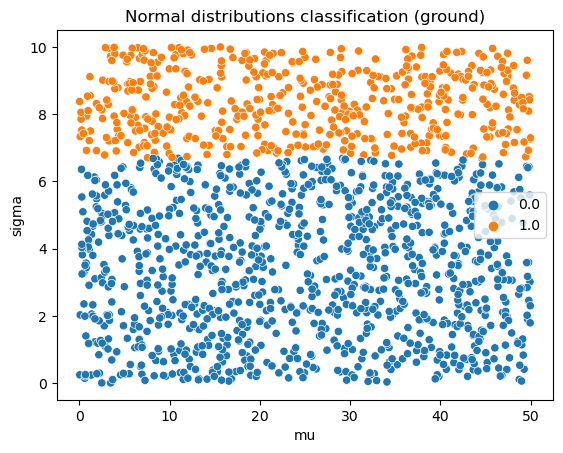

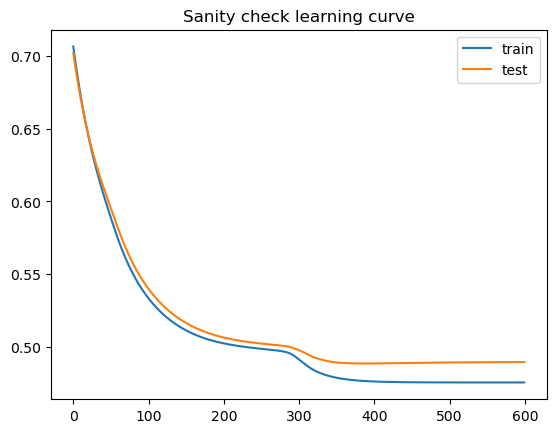

1/9 iters
2/9 iters
3/9 iters
4/9 iters
5/9 iters
6/9 iters
7/9 iters
8/9 iters
9/9 iters


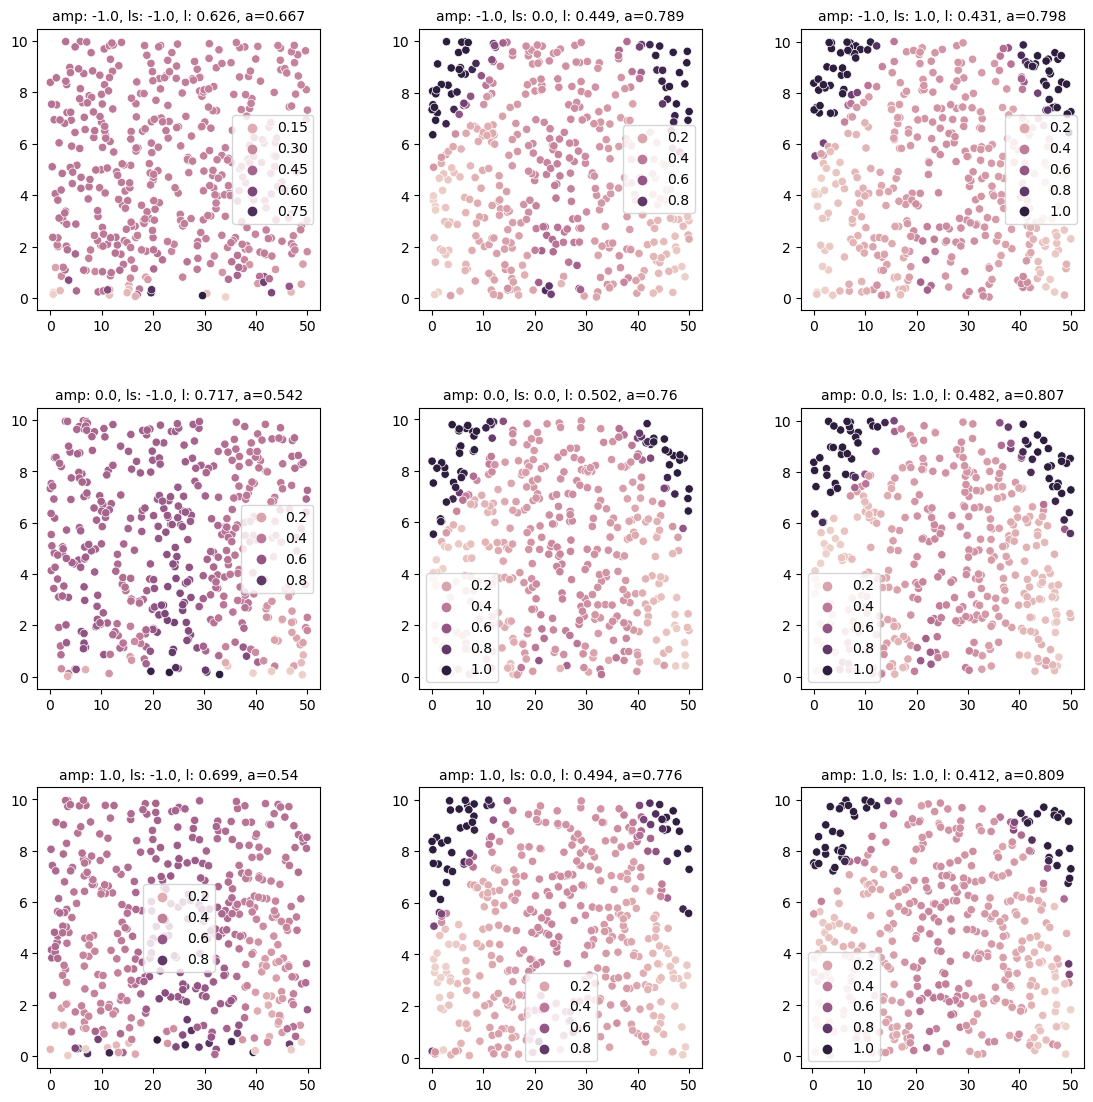

In [27]:
n_dim = 1

n_distributions = 1500
samples_per_dist = 20000

normals_mu_range = (0, 50)
normals_sigma_range = (0, 10)
class_sigma_threshold = 6.7

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_hline = normal_dists.bin_sigma_gt_labels(class_sigma_threshold)

logistic_gp = DistributionLogisticGP(
    normal_dists, normal_labels_hline, rff_encoder
)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_hline,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_features = 32
train_ratio = 0.7
epochs = 600
lr = 0.00075

rff_encoder = RffEncoder(
    n_features,
    n_dim,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=0.0,
)

log_amplitudes = [-1.0, 0.0, 1.0]
log_length_scales = [-1.0, 0.0, 1.0]
kernel = "gaussian"

###
###

# Check whether the loss converges for given lr/epochs
train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    epochs,
    batch_size,
    bfgs=True,
)
plot = sns.lineplot(train_losses, label="train")
sns.lineplot(test_losses, label="test")
plot.set_title("Sanity check learning curve")
plt.show()

rows = len(log_amplitudes)
cols = len(log_length_scales)
iters = rows * cols

fig, axs = plt.subplots(
    rows,
    cols,
    figsize=(4.5 * cols, 4.5 * rows),
)
plt.subplots_adjust(
    hspace=0.35,
    wspace=0.35,
)

c_iter = 0
for idx, log_amplitude in enumerate(log_amplitudes):
    for idy, log_lengt_scale in enumerate(log_length_scales):
        logistic_gp.set_rff_kernel_params(
            log_amplitude, log_lengt_scale, kernel
        )
        train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

        model = LogisticRegression(n_features).to(device, dtype=torch.float64)
        optimizer = torch.optim.LBFGS(model.parameters(), lr)

        train_losses, test_losses = train_model(
            model,
            optimizer,
            train_dataset,
            test_dataset,
            epochs,
            batch_size,
            bfgs=True,
        )

        test_data, labels, test_dists = next(
            iter(DataLoader(test_dataset, batch_size=len(test_dataset)))
        )

        with torch.no_grad():
            y_test = model(test_data).flatten()

        test_loss = round(test_losses[-1], 3)
        accuracy = round(BinaryAccuracy()(y_test, labels).item(), 3)

        sns.scatterplot(
            x=test_dists[:, 0],
            y=test_dists[:, 1],
            hue=y_test[:],
            ax=axs[idx, idy],
        )

        axs[idx, idy].set_title(
            f"amp: {log_amplitude}, ls: {log_lengt_scale}, l: {test_loss}, a={accuracy}",
            fontdict={"fontsize": 10},
        )

        c_iter += 1
        print(f"{c_iter}/{iters} iters")

plt.show()

#### Same sigma classification as above (across larger spread), but on a laplace distribution

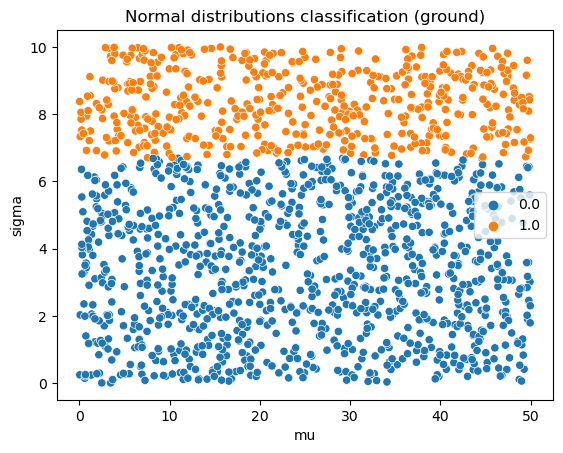

Epoch: 0, train loss = 0.6893, test loss = 0.6885
Epoch: 50, train loss = 0.5076, test loss = 0.5362
Epoch: 100, train loss = 0.3967, test loss = 0.4463
Epoch: 150, train loss = 0.3088, test loss = 0.3666
Epoch: 200, train loss = 0.2366, test loss = 0.2918
Epoch: 250, train loss = 0.1868, test loss = 0.2353
Epoch: 300, train loss = 0.1571, test loss = 0.2011
Epoch: 350, train loss = 0.1407, test loss = 0.1882
Epoch: 400, train loss = 0.1325, test loss = 0.1877
Epoch: 450, train loss = 0.1272, test loss = 0.1900
Epoch: 500, train loss = 0.1212, test loss = 0.1928
Epoch: 550, train loss = 0.1125, test loss = 0.1943


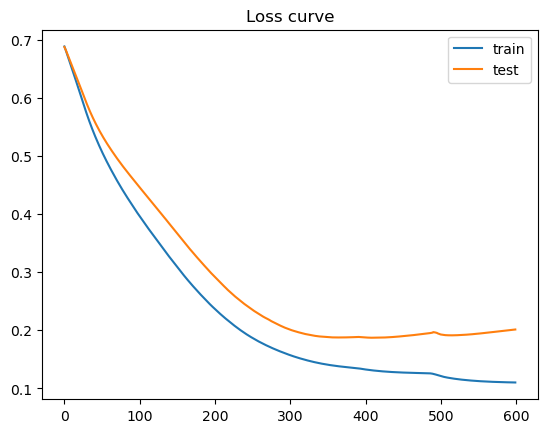

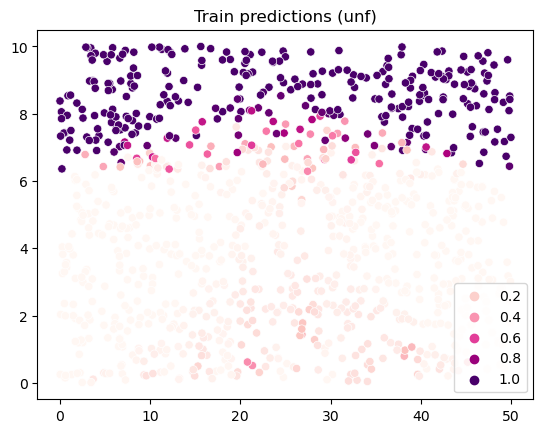

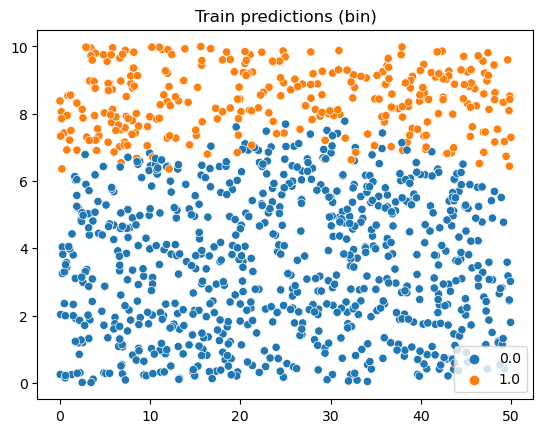

Train Accuracy: 0.961904764175415


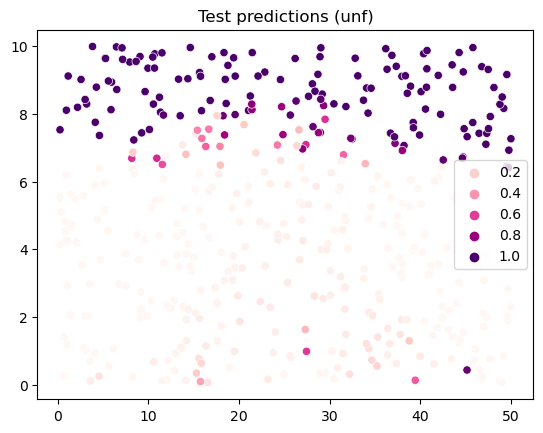

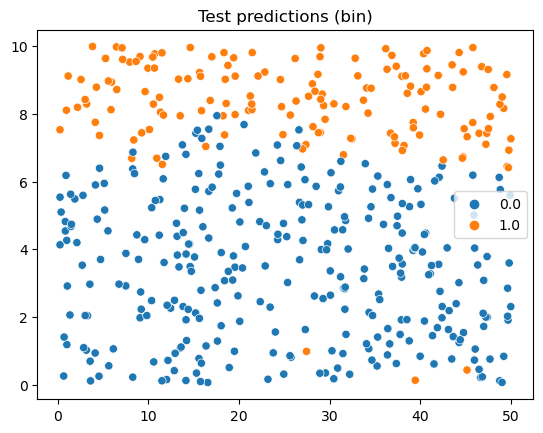

Test accuracy: 0.9444444179534912


In [20]:
n_dim = 1

n_distributions = 1500
samples_per_dist = 20000

normals_mu_range = (0, 50)
normals_sigma_range = (0, 10)
class_sigma_threshold = 6.7

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range, subclass='laplacian'
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_hline = normal_dists.bin_sigma_gt_labels(class_sigma_threshold)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_hline,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_features = 32
train_ratio = 0.7

rff_encoder = RffEncoder(
    n_features,
    n_dim,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=0.0,
)

logistic_gp = DistributionLogisticGP(
    normal_dists, normal_labels_hline, rff_encoder
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.00075)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    600,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

#### Classify uniformly-spread normals on sigma curve threshold

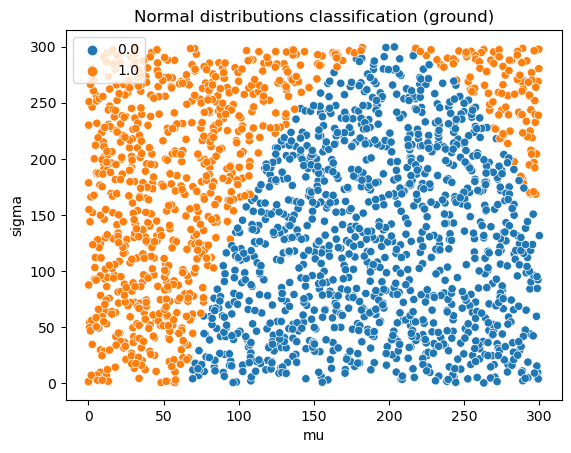

Epoch: 50, train loss = 0.5463, test loss = 0.5441
Epoch: 100, train loss = 0.4393, test loss = 0.4367
Epoch: 150, train loss = 0.3589, test loss = 0.3567
Epoch: 200, train loss = 0.2968, test loss = 0.2953
Epoch: 250, train loss = 0.2477, test loss = 0.2472
Epoch: 300, train loss = 0.2084, test loss = 0.2090
Epoch: 350, train loss = 0.1765, test loss = 0.1784
Epoch: 400, train loss = 0.1503, test loss = 0.1537
Epoch: 450, train loss = 0.1286, test loss = 0.1337
Epoch: 500, train loss = 0.1105, test loss = 0.1173
Epoch: 550, train loss = 0.0953, test loss = 0.1040
Epoch: 600, train loss = 0.0825, test loss = 0.0931
Epoch: 650, train loss = 0.0716, test loss = 0.0843
Epoch: 700, train loss = 0.0623, test loss = 0.0771
Epoch: 750, train loss = 0.0543, test loss = 0.0713
Epoch: 800, train loss = 0.0473, test loss = 0.0666
Epoch: 850, train loss = 0.0413, test loss = 0.0630
Epoch: 900, train loss = 0.0359, test loss = 0.0603
Epoch: 950, train loss = 0.0312, test loss = 0.0588
Epoch: 1000, 

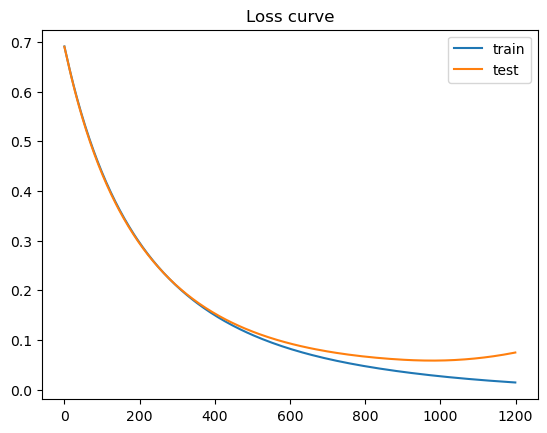

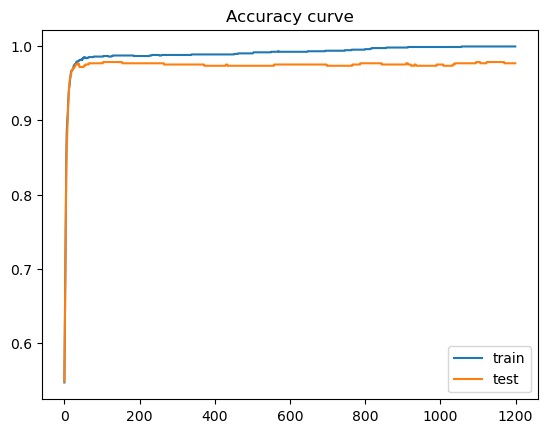

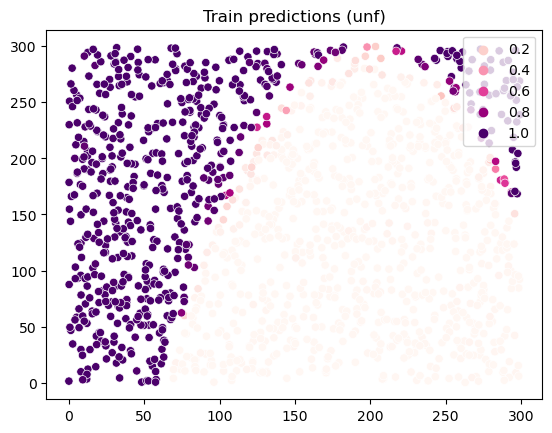

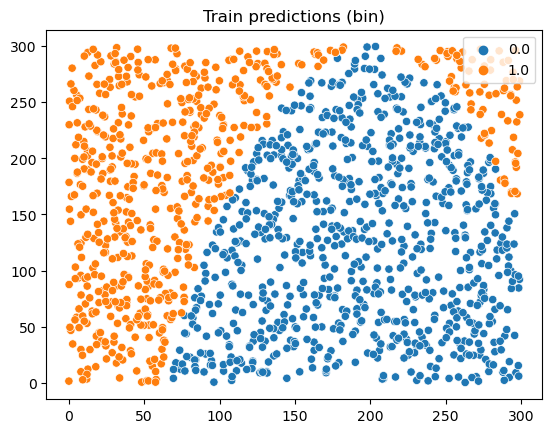

Train Accuracy: 99.929


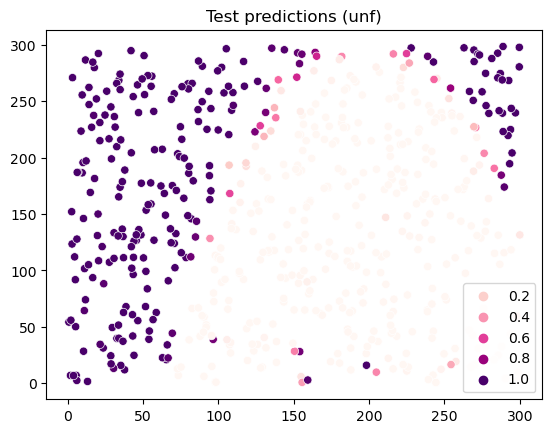

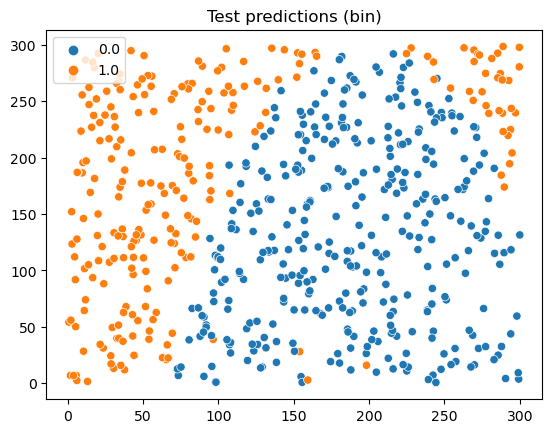

Test accuracy: 97.667


In [33]:
n_dim = 1

n_distributions = 2000
samples_per_dist = 25000

normals_mu_range = (0, 300)
normals_sigma_range = (0, 300)
class_sigma_threshold = 100

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_parab = (
    normal_dists.params[:, 1] > -(((normal_dists.params[:, 0] - 200) / 8) ** 2) + 300
).astype(float)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_parab,
)
plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_kme_features = 200
n_features = 200
train_ratio = 0.7

kme_rff_encoder = RffEncoder(
    n_dim,
    n_kme_features,
    kernel="gaussian",
    log_amplitude=1.0,
    log_length_scale=4.0,
)

reg_rff_encoder = RffEncoder(
    n_kme_features,
    n_features,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=-1.0,
)

logistic_gp = DistributionLogisticGP(
    normal_dists,
    normal_labels_parab,
    kme_rff_encoder,
    reg_rff_encoder,
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0002)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    1200,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

#### Using squared polynomial features

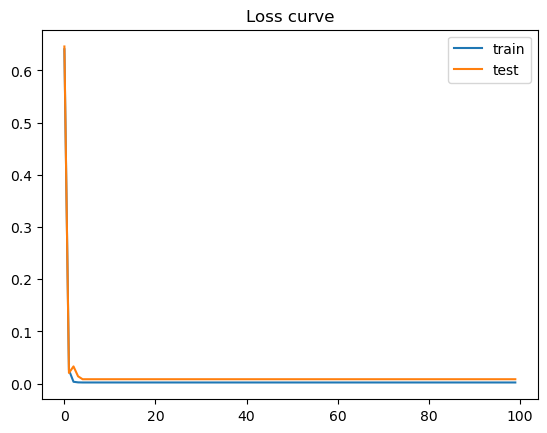

[[479.78509213  51.66847028]
 [137.67421048   7.35116086]] [[ 1.58640711  1.95730493  1.95731234  2.39915114]
 [-0.76089323 -0.85277494 -0.85223094 -0.72324041]]


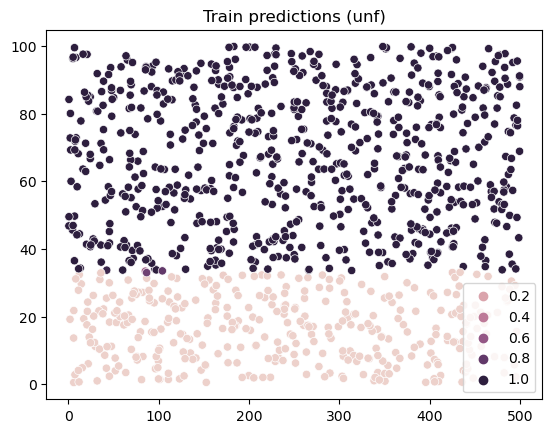

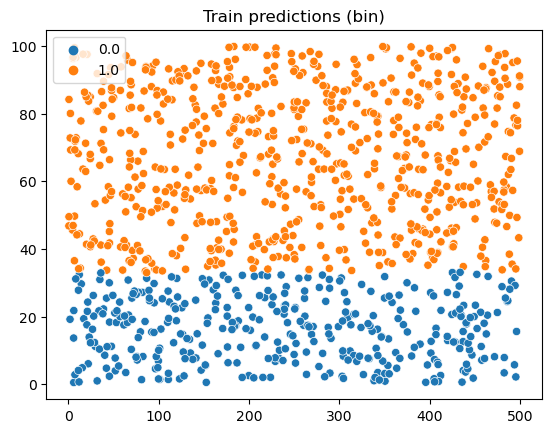

Train Accuracy: 0.9990476369857788


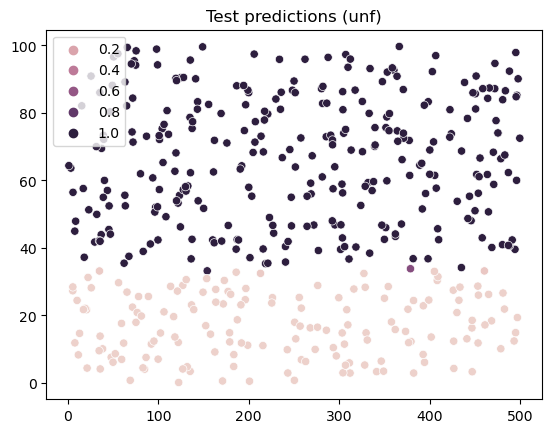

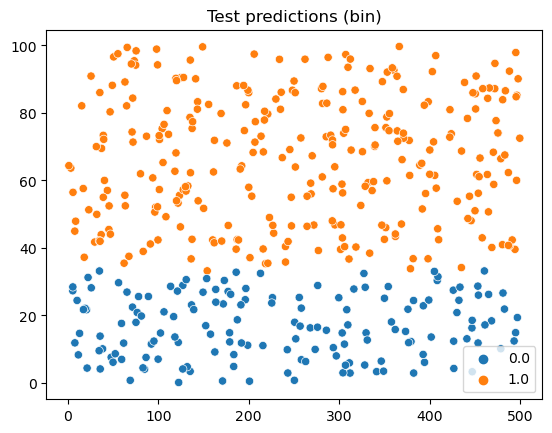

Test accuracy: 0.9977777600288391


In [56]:
squared_poly_encoder = PolynomialEncoder()

logistic_gp = DistributionLogisticGP(
    normal_dists, normal_labels_hline, squared_poly_encoder
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(4, bias=True).to(device, dtype=torch.float64)
optimizer = torch.optim.LBFGS(
    model.parameters(),
    line_search_fn="strong_wolfe",
)
# optimizer = torch.optim.Adamax(model.parameters(), lr=2.)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    100,
    plot_curve=True,
    bfgs=True,
)

print(normal_dists.params[:2], logistic_gp.mean_embeddings[:2])

train_data, labels, train_dists = next(
    iter(DataLoader(train_dataset, batch_size=len(train_dataset)))
)
with torch.no_grad():
    y_train = model(train_data).flatten()
    plot = sns.scatterplot(
        x=train_dists[:, 0], y=train_dists[:, 1], hue=y_train[:]
    )
    plot.set_title("Train predictions (unf)")
    plt.show()
    plot = sns.scatterplot(
        x=train_dists[:, 0], y=train_dists[:, 1], hue=torch.round(y_train[:])
    )
    plot.set_title("Train predictions (bin)")
    plt.show()
print(f"Train Accuracy: {BinaryAccuracy()(y_train, labels)}")

test_data, labels, test_dists = next(
    iter(DataLoader(test_dataset, batch_size=len(test_dataset)))
)
with torch.no_grad():
    y_test = model(test_data).flatten()
    plot = sns.scatterplot(
        x=test_dists[:, 0], y=test_dists[:, 1], hue=y_test[:]
    )
    plot.set_title("Test predictions (unf)")
    plt.show()
    plot = sns.scatterplot(
        x=test_dists[:, 0], y=test_dists[:, 1], hue=torch.round(y_test[:])
    )
    plot.set_title("Test predictions (bin)")
    plt.show()

print(f"Test accuracy: {BinaryAccuracy()(y_test, labels)}")

#### Normals circular threshold 

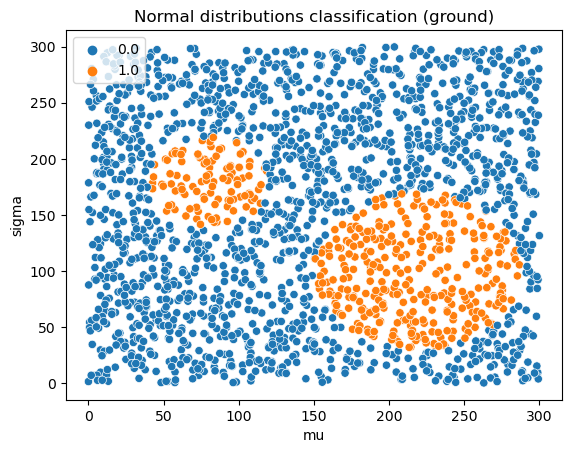

Epoch: 50, train loss = 0.5455, test loss = 0.5476
Epoch: 100, train loss = 0.4400, test loss = 0.4432
Epoch: 150, train loss = 0.3604, test loss = 0.3646
Epoch: 200, train loss = 0.2987, test loss = 0.3041
Epoch: 250, train loss = 0.2499, test loss = 0.2564
Epoch: 300, train loss = 0.2108, test loss = 0.2185
Epoch: 350, train loss = 0.1790, test loss = 0.1880
Epoch: 400, train loss = 0.1530, test loss = 0.1634
Epoch: 450, train loss = 0.1315, test loss = 0.1435
Epoch: 500, train loss = 0.1136, test loss = 0.1273
Epoch: 550, train loss = 0.0985, test loss = 0.1142
Epoch: 600, train loss = 0.0858, test loss = 0.1038
Epoch: 650, train loss = 0.0749, test loss = 0.0957
Epoch: 700, train loss = 0.0656, test loss = 0.0895
Epoch: 750, train loss = 0.0577, test loss = 0.0853
Epoch: 800, train loss = 0.0508, test loss = 0.0827
Epoch: 850, train loss = 0.0448, test loss = 0.0817
Epoch: 900, train loss = 0.0395, test loss = 0.0822
Epoch: 950, train loss = 0.0349, test loss = 0.0840
Epoch: 1000, 

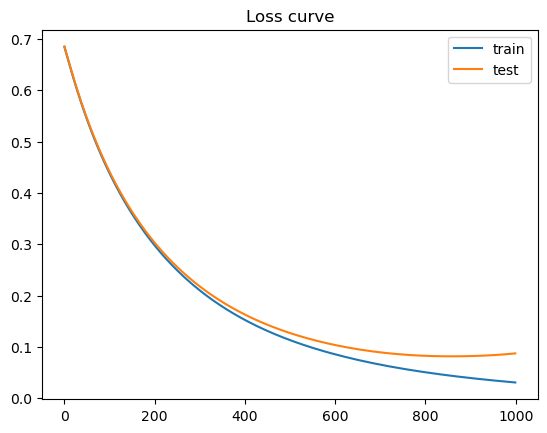

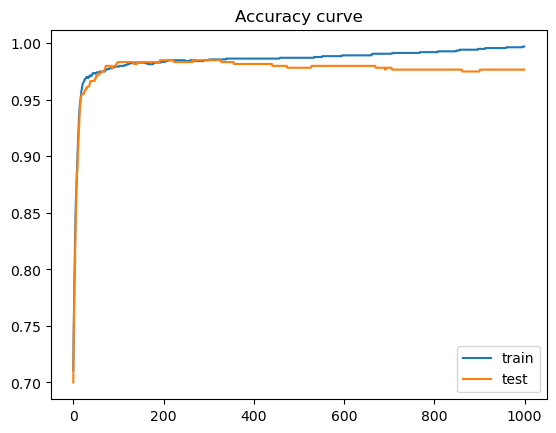

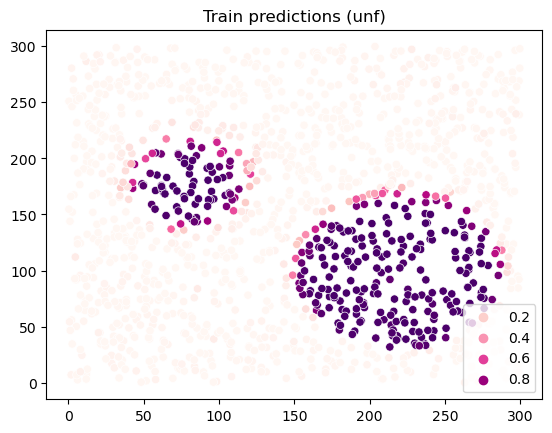

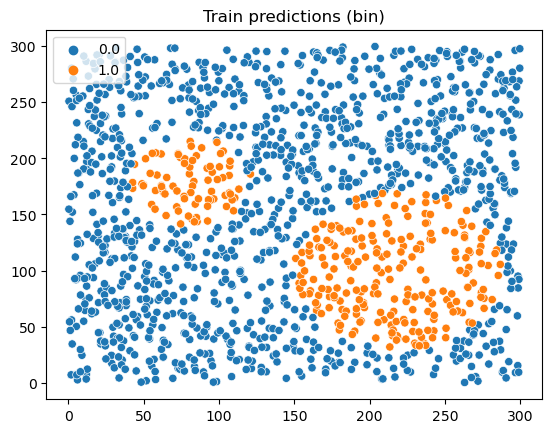

Train Accuracy: 99.714


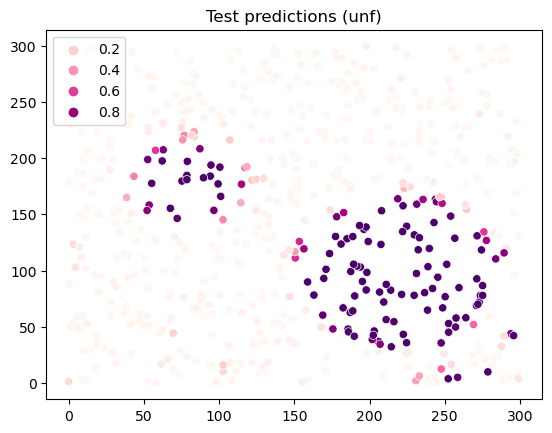

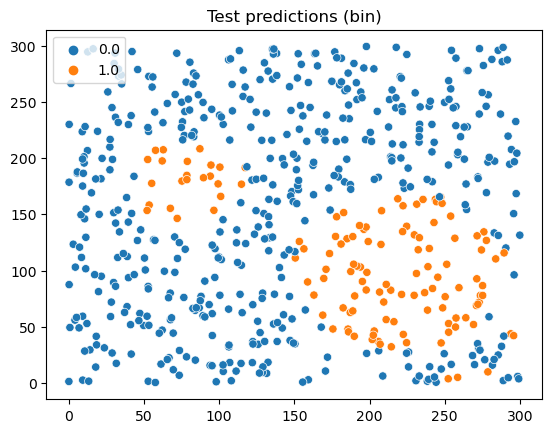

Test accuracy: 97.667


In [13]:
n_dim = 1

n_distributions = 2000
samples_per_dist = 25000

normals_mu_range = (0, 300)
normals_sigma_range = (0, 300)

p1_x, p1_y, p1_d = 80, 180, 40
p2_x, p2_y, p2_d = 220, 100, 70

normal_dists = distributions.Normal(
    n_distributions, n_dim, normals_mu_range, normals_sigma_range
)
_ = normal_dists.sample(samples_per_dist)

normal_labels_parab = (
    (
        np.sqrt(
            (normal_dists.params[:, 0] - p1_x) ** 2
            + (normal_dists.params[:, 1] - p1_y) ** 2
        )
        <= p1_d
    )
    | (
        np.sqrt(
            (normal_dists.params[:, 0] - p2_x) ** 2
            + (normal_dists.params[:, 1] - p2_y) ** 2
        )
        <= p2_d
    )
).astype(float)

plot = sns.scatterplot(
    x=normal_dists.params[:, 0],
    y=normal_dists.params[:, 1],
    hue=normal_labels_parab,
)

plot.set(
    xlabel="mu",
    ylabel="sigma",
    title="Normal distributions classification (ground)",
)
plt.show()

n_kme_features = 200
n_features = 200
train_ratio = 0.7

kme_rff_encoder = RffEncoder(
    n_dim,
    n_kme_features,
    kernel="gaussian",
    log_amplitude=1.0,
    log_length_scale=4.0,
)

reg_rff_encoder = RffEncoder(
    n_kme_features,
    n_features,
    kernel="gaussian",
    log_amplitude=0.0,
    log_length_scale=-1.0,
)

logistic_gp = DistributionLogisticGP(
    normal_dists,
    normal_labels_parab,
    kme_rff_encoder,
    reg_rff_encoder,
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0002)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    1000,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_normals_predictions(model, train_dataset, test_dataset)

## Classify different distribution classes

#### Classify normals vs uniforms

Epoch: 50, train loss = 0.5660, test loss = 0.5666
Epoch: 100, train loss = 0.4580, test loss = 0.4600
Epoch: 150, train loss = 0.3759, test loss = 0.3802
Epoch: 200, train loss = 0.3125, test loss = 0.3193
Epoch: 250, train loss = 0.2629, test loss = 0.2722
Epoch: 300, train loss = 0.2237, test loss = 0.2352
Epoch: 350, train loss = 0.1922, test loss = 0.2059
Epoch: 400, train loss = 0.1666, test loss = 0.1823
Epoch: 450, train loss = 0.1455, test loss = 0.1632
Epoch: 500, train loss = 0.1281, test loss = 0.1475
Epoch: 550, train loss = 0.1137, test loss = 0.1348
Epoch: 600, train loss = 0.1017, test loss = 0.1244
Epoch: 650, train loss = 0.0916, test loss = 0.1158
Epoch: 700, train loss = 0.0830, test loss = 0.1089
Epoch: 750, train loss = 0.0756, test loss = 0.1033
Epoch: 800, train loss = 0.0693, test loss = 0.0989
Epoch: 850, train loss = 0.0637, test loss = 0.0955
Epoch: 900, train loss = 0.0588, test loss = 0.0931
Epoch: 950, train loss = 0.0546, test loss = 0.0915
Epoch: 1000, 

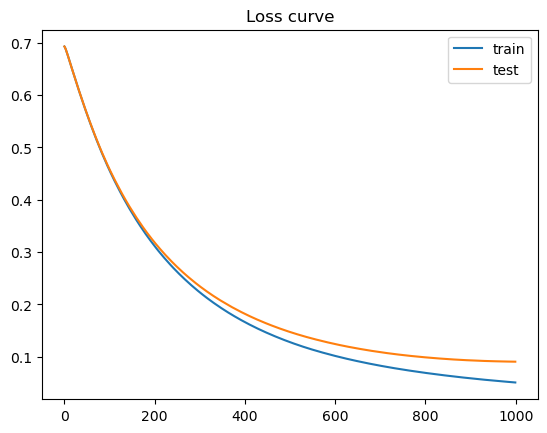

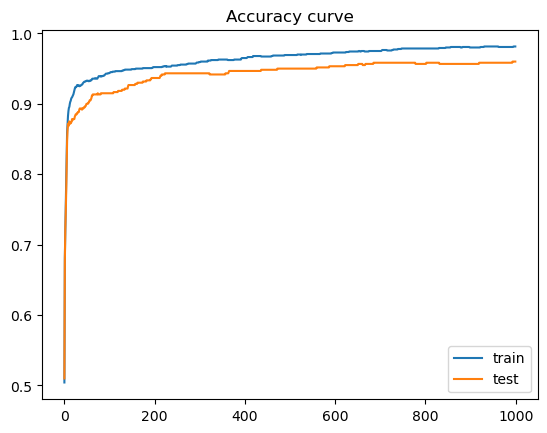

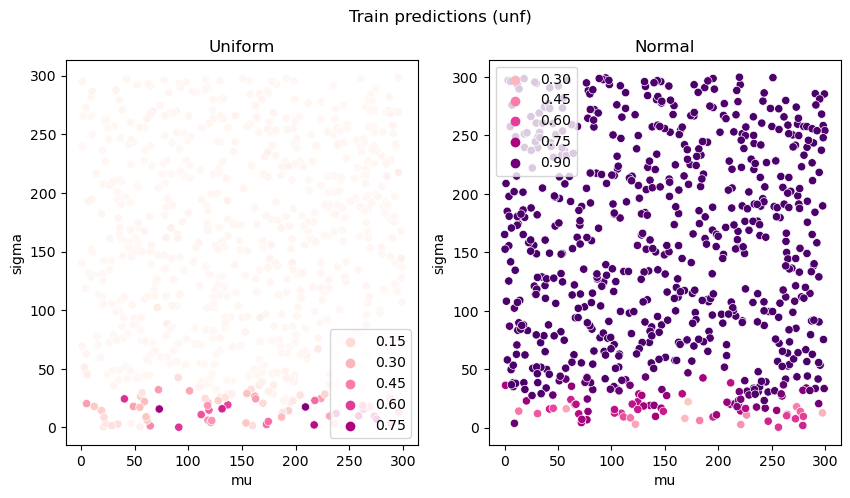

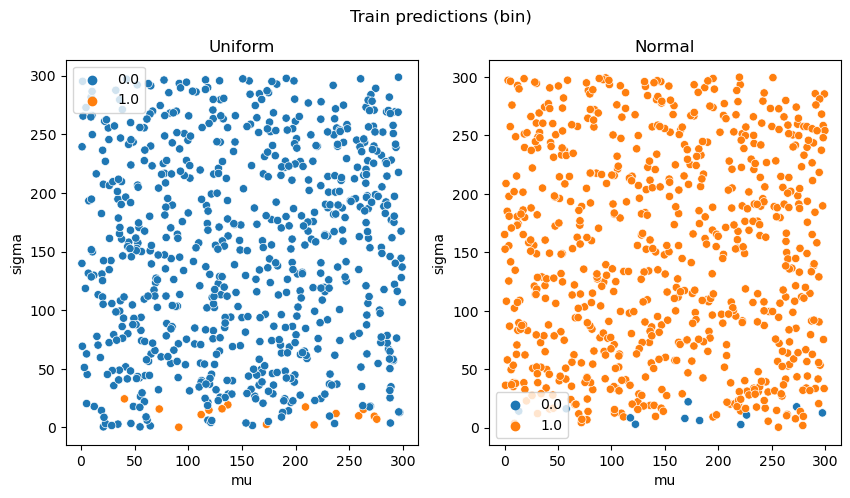

Train Accuracy: 98.143


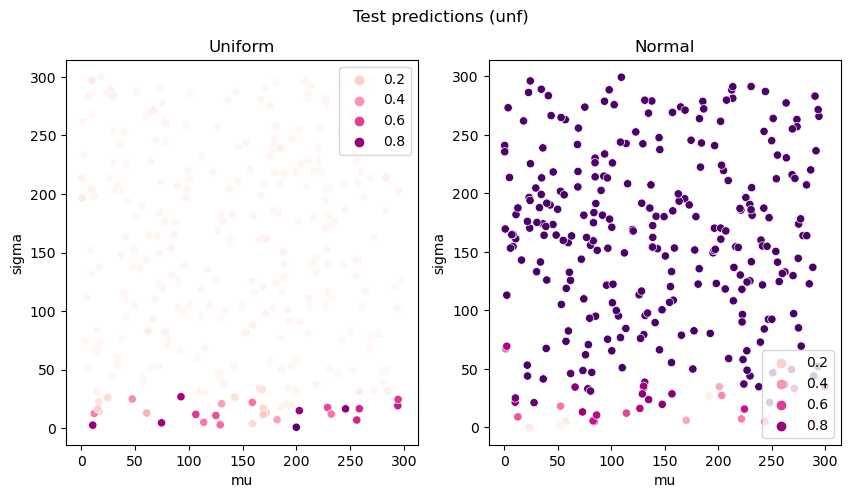

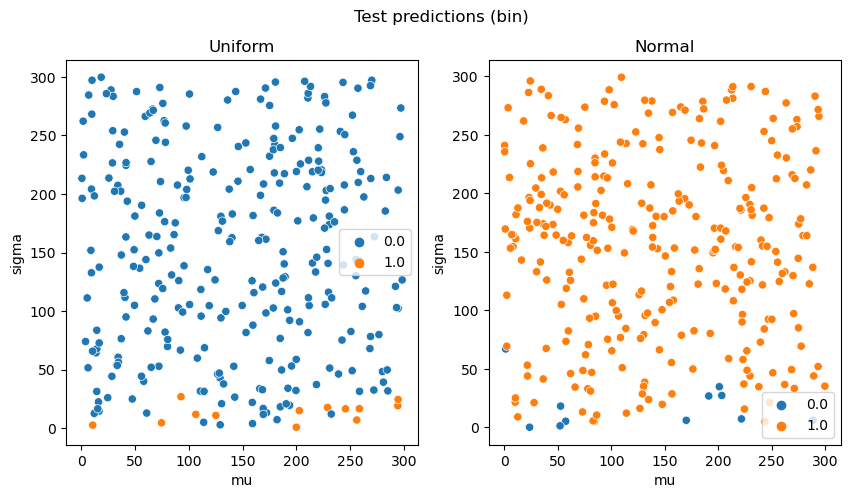

Test accuracy: 96.0


In [55]:
n_dim = 1

n_distributions_each = 1000
mu_range = (0, 300)
sigma_range = (0, 300)

samples_per_dist = 12_500

normal_dists = distributions.Normal(
    n_distributions_each, n_dim, mu_range, sigma_range, subclass="normal"
)
uniform_dists = distributions.Uniform(
    n_distributions_each, n_dim, mu_range, sigma_range
)

normal_dists.sample(samples_per_dist)
uniform_dists.sample(samples_per_dist)

two_class_dists = concatenate_distributions([normal_dists, uniform_dists])

binary_class_labels = (
    two_class_dists.params[:, 2] == DIST_CLASSES["normal"]
).astype(float)

n_kme_features = 200
n_features = 200
train_ratio = 0.7

kme_rff_encoder = RffEncoder(
    n_dim,
    n_kme_features,
    kernel="gaussian",
    log_amplitude=1.5,
    log_length_scale=4.0,
)

reg_rff_encoder = RffEncoder(
    n_kme_features,
    n_features,
    kernel="gaussian",
    log_amplitude=-2.0,
    log_length_scale=1.0,
)

logistic_gp = DistributionLogisticGP(
    two_class_dists,
    binary_class_labels,
    kme_rff_encoder,
    reg_rff_encoder,
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(model.parameters(), lr=0.0002)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    1000,
    batch_size,
    bfgs=True,
    verbose=True,
    plot_curve=True,
)

plot_bin_class_predictions(
    model, train_dataset, test_dataset, class_labels=("Uniform", "Normal")
)

##### Grid search

In [ ]:
def grid_search(
    log_amplitudes,
    log_length_scales,
    class_labels,
    epochs=10,
    lr=0.01,
    n_features=25,
    kernel="gaussian",
    train_ratio=0.7,
):
    n_dims = 1

    rff_encoder = RffEncoder(n_features, n_dims, kernel=kernel)
    logistic_gp = DistributionLogisticGP(
        two_class_dists, class_labels, rff_encoder
    )

    # Check whether the loss converges for given lr/epochs
    train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

    model = LogisticRegression(n_features).to(device, dtype=torch.float64)
    # optimizer = torch.optim.LBFGS(
    #     model.parameters(), line_search_fn="strong_wolfe"
    # )
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = train_model(
        model,
        optimizer,
        train_dataset,
        test_dataset,
        epochs,  # bfgs=True
    )
    sns.lineplot(train_losses, label="train")
    sns.lineplot(test_losses, label="test")
    plt.show()

    rows = len(log_amplitudes)
    cols = len(log_length_scales)
    iters = rows * cols

    fig, axs = plt.subplots(
        rows,
        cols,
        figsize=(4.5 * cols, 4.5 * rows),
    )
    plt.subplots_adjust(
        hspace=0.35,
        wspace=0.35,
    )

    c_iter = 0
    for idx, log_amplitude in enumerate(log_amplitudes):
        for idy, log_lengt_scale in enumerate(log_length_scales):
            logistic_gp.set_rff_kernel_params(
                log_amplitude, log_lengt_scale, kernel
            )
            train_dataset, test_dataset = logistic_gp.as_split_dataset(
                train_ratio
            )

            model = LogisticRegression(n_features).to(
                device, dtype=torch.float64
            )
            # optimizer = torch.optim.LBFGS(
            #     model.parameters(), line_search_fn="strong_wolfe"
            # )
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            train_losses, test_losses = train_model(
                model,
                optimizer,
                train_dataset,
                test_dataset,
                epochs,
                # bfgs=True,
            )

            test_data, labels, test_dists = next(
                iter(DataLoader(test_dataset, batch_size=len(test_dataset)))
            )

            with torch.no_grad():
                y_test = model(test_data).flatten()

            test_loss = round(test_losses[-1], 3)
            accuracy = round(BinaryAccuracy()(y_test, labels).item(), 3)

            sns.scatterplot(
                x=test_dists[:, 2],
                y=test_dists[:, 1],
                hue=y_test[:],
                ax=axs[idx, idy],
            )

            axs[idx, idy].set_title(
                f"amp: {log_amplitude}, ls: {log_lengt_scale}, l: {test_loss}, a={accuracy}",
                fontdict={"fontsize": 10},
            )

            c_iter += 1
            print(f"{c_iter}/{iters} iters")

    plt.show()

In [ ]:
log_amplitudes = [-1.5, -1.0, -0.5, 0.0]
log_length_scales = [-2.0, -1.0]

log_amplitudes = [-2.0, -1.0, 0.0]
log_length_scales = [0.0, 2.0, 3.0]

log_amplitudes = [-2.0, 0.0, 2.0]
log_length_scales = [-2.0, 0.0, 2.0]

grid_search(
    log_amplitudes,
    log_length_scales,
    bin_class_labels,
    epochs=1500,
    lr=6.0,
    n_features=35,
    kernel="gaussian",
    train_ratio=0.7,
)

#### Classify laplacians vs normals & uniforms

In [82]:
n_dim = 1

n_distributions_each = 500
mu = 0
mu = (0, 10)
sigma_range = (0, 10)
# sigma_range = 1

samples_per_dist = 20000

normal_dists = distributions.Normal(
    n_distributions_each, n_dim, mu, sigma_range, subclass="normal"
)
laplace_dists = distributions.Normal(
    n_distributions_each, n_dim, mu, sigma_range, subclass="laplacian"
)

gamma_dists = distributions.Normal(
    n_distributions_each, n_dim, mu, sigma_range, subclass="gamma"
)

uniform_dists = distributions.Uniform(
    n_distributions_each, n_dim, mu, sigma_range
)

normal_dists.sample(samples_per_dist)
laplace_dists.sample(samples_per_dist)
gamma_dists.sample(samples_per_dist)
uniform_dists.sample(samples_per_dist)

two_class_dists = concatenate_distributions(normal_dists, uniform_dists)
three_class_dists = concatenate_distributions(
    concatenate_distributions(
        concatenate_distributions(normal_dists, uniform_dists), laplace_dists
    ),
    gamma_dists,
)

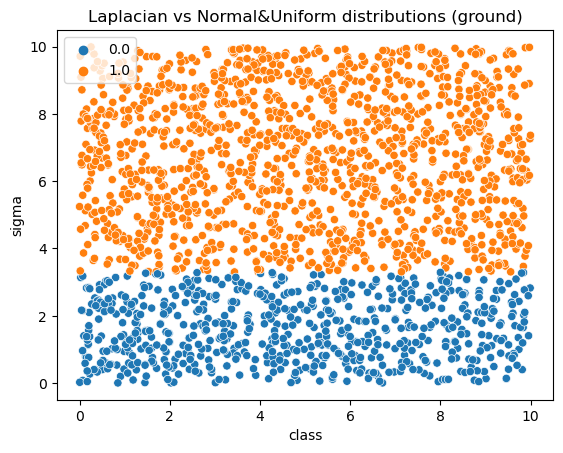

In [83]:
bin_class_labels = three_class_dists.bin_dist_class_labels(2)
bin_class_labels = three_class_dists.bin_sigma_gt_labels(3.3)
plot = sns.scatterplot(
    x=three_class_dists.params[:, 0],
    y=three_class_dists.params[:, 1],
    hue=bin_class_labels,
)
plot.set(
    xlabel="class",
    ylabel="sigma",
    title="Laplacian vs Normal&Uniform distributions (ground)",
)
plt.show()

In [84]:
label_dict = {"uniform": 0, "normal": 1, "laplacian": 2}

Epoch: 0, train loss = 0.6928, test loss = 0.6935
Epoch: 50, train loss = 0.4921, test loss = 0.4997
Epoch: 100, train loss = 0.4090, test loss = 0.4231
Epoch: 150, train loss = 0.3666, test loss = 0.3851
Epoch: 200, train loss = 0.3439, test loss = 0.3635
Epoch: 250, train loss = 0.3331, test loss = 0.3522
Epoch: 300, train loss = 0.3286, test loss = 0.3466
Epoch: 350, train loss = 0.3260, test loss = 0.3429
Epoch: 400, train loss = 0.3248, test loss = 0.3404
Epoch: 450, train loss = 0.3244, test loss = 0.3391
Epoch: 500, train loss = 0.3225, test loss = 0.3370
Epoch: 550, train loss = 0.3210, test loss = 0.3341
Epoch: 600, train loss = 0.3202, test loss = 0.3315
Epoch: 650, train loss = 0.3197, test loss = 0.3306
Epoch: 700, train loss = 0.3195, test loss = 0.3302
Epoch: 750, train loss = 0.3193, test loss = 0.3300
Epoch: 800, train loss = 0.3183, test loss = 0.3301
Epoch: 850, train loss = 0.3178, test loss = 0.3312
Epoch: 900, train loss = 0.3177, test loss = 0.3320
Epoch: 950, tra

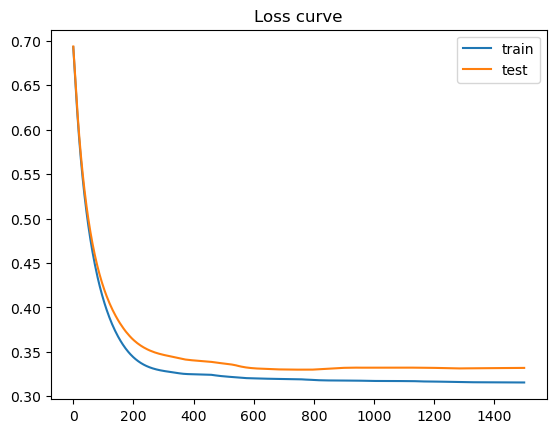

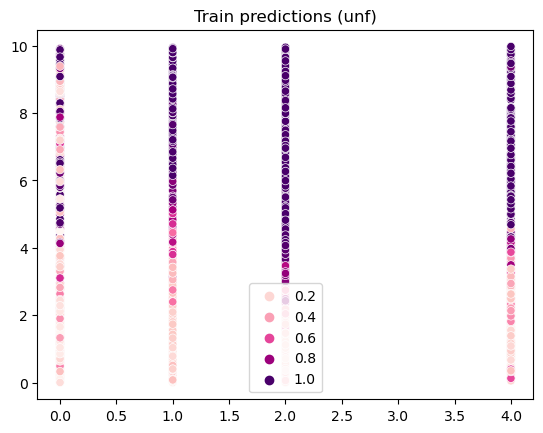

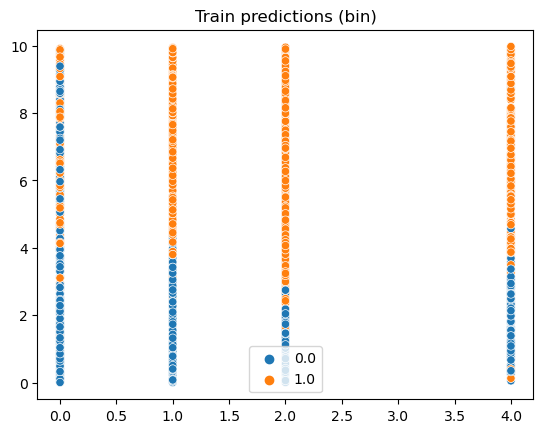

Train Accuracy: 0.852142870426178


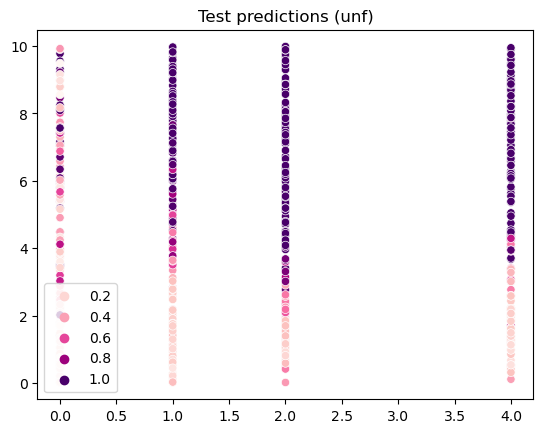

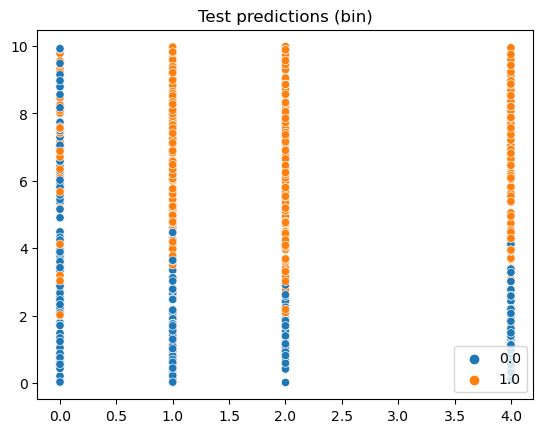

Test accuracy: 0.8550000190734863


In [88]:
from distreg.utils import plot_bin_class_predictions


n_features = 150
train_ratio = 0.7

rff_encoder = RffEncoder(
    n_features,
    n_dim,
    kernel="laplacian",
    # log_amplitude=-1.0,
    # log_length_scale=-2.0,
    log_amplitude=0.3,
    log_length_scale=0.5,
)

logistic_gp = DistributionLogisticGP(
    three_class_dists, bin_class_labels, rff_encoder
)

train_dataset, test_dataset = logistic_gp.as_split_dataset(train_ratio)

model = LogisticRegression(n_features).to(device, dtype=torch.float64)

optimizer = torch.optim.LBFGS(
    model.parameters(),
    #lr=0.0008,
    lr=0.0008,
    # ,line_search_fn="strong_wolfe",
)
# optimizer = torch.optim.Adam(model.parameters(), lr=3.0)

train_losses, test_losses = train_model(
    model,
    optimizer,
    train_dataset,
    test_dataset,
    1500,
    bfgs=True,
    batch_size=16,
    verbose=True,
    plot_curve=True,
)

plot_bin_class_predictions(
    model, train_dataset, test_dataset, {0: "normal", 1: "uniform"}
)

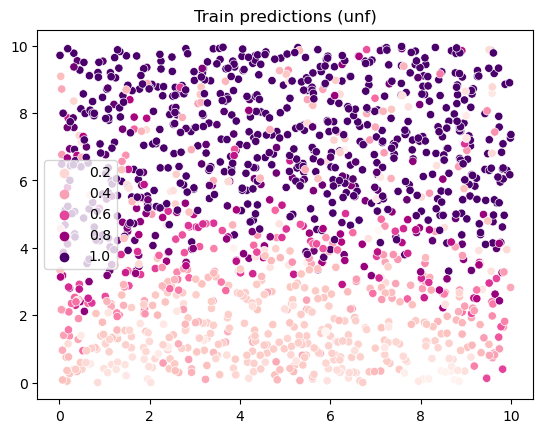

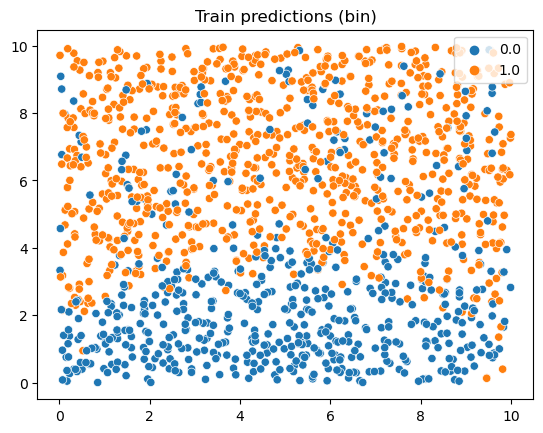

Train Accuracy: 0.852142870426178


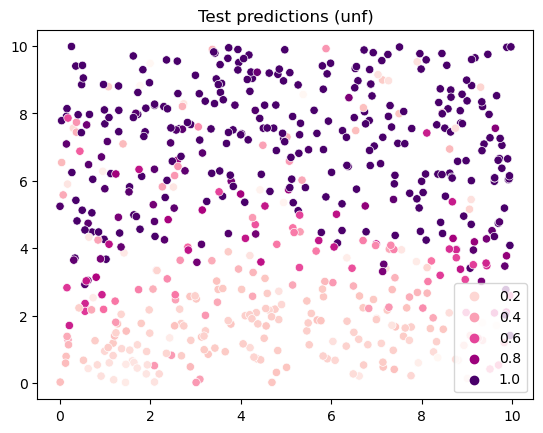

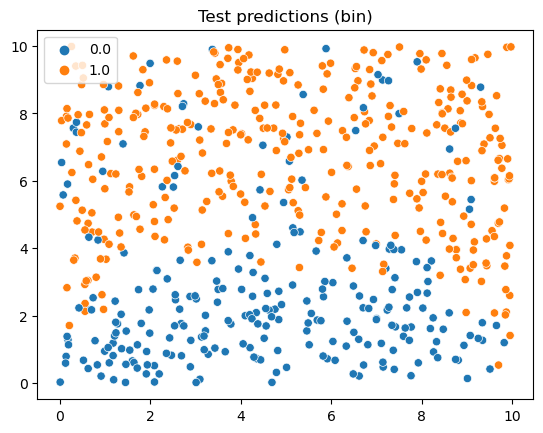

Test accuracy: 0.8550000190734863


In [89]:
plot_normals_predictions(model, train_dataset, test_dataset)